# Section 4: Use a Catalog to Visualize Objects in the Map

This notebook will demonstrate how a catalog can be used to visualize objects in the maps and will also show users how to stack on the pointsources in the catalog.

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to AdvACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps from [Naess et al. (2020)](https://www.overleaf.com/5395816498bsknshgxbmyr) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al. (2020)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_power_spectra_part_1.ipynb): Harmonic Analysis using CAR maps [Naess et al, in preparation]

> [Section 8](Section_8_power_spectra_part_2.ipynb) Power Spectrum example using Nawrapper [Aiola et al] and [Choi et al] 

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code
 
> [Section 12](Section_12_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020, in preparation]
---

## Initialize notebook

Again, we rerun the first notebook in order to import packages and set the data path.  From there we will read in the coadded map.  Users can choose to import the lower resolution map or the full resolution map depending on their computer's capabilities.  To that end make the appropriate choice for your computer and edit the code if need be.

In [1]:
%run Section_1_Introduction.ipynb

# Redefine our plotting function from section 2
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [2]:
# read in the coadded map.  
# This defaults to the down graded map, to switch to the full resolution replace fname_dg with fname_full

fname_dg = "act_planck_dr4.01_s08s16_AA_f150_night_map_dg_I.fits"
fname_full = "act_planck_dr4.01_s08s16_AA_f150_night_map.fits"

# Set the size of the box in degrees and convert to radians
dec_from, dec_to = np.deg2rad([-40,-10])
ra_from, ra_to = np.deg2rad([-25, 25])
box = [[dec_from,ra_from],[dec_to,ra_to]]

# read in the map
# We default to the downgraded map here but if you are able to use the full map the resolution will be much
# better so we encourage you to use that if possible.
# To do so switch to "fname_full"  and use the box=box command in enmap.read_map to read in a subsection of the map
# You can also add [0] after the command to select only the intensity map if using the full map

imap = enmap.read_map(path + fname_dg)

## Begin Analysis

In the maps above it's already possible to see a few galaxy clusters just by visually examining the map.  However it would be great to be able to look at these more closely.  One option is to use a catalog of clusters and compare the catalog to the map.  In order to do so we need to get the RA and DEC of the relevant sources and then cut a box surrounding that location.

In [3]:
from astropy.io import fits

# Read in ras and decs from a cluster catalog

hdu = fits.open(path + 'E-D56Clusters.fits')
ras = hdu[1].data['RADeg']
decs = hdu[1].data['DECDeg']

As noted previously, one way to look at a source is to build a "bounding box" and to call the `submap` method.  Let's make the box slightly smaller this time in order to hone in on the objects we are interested in.  

This time we will use enplot's upgrade feature in order to plot a larger image of the object.

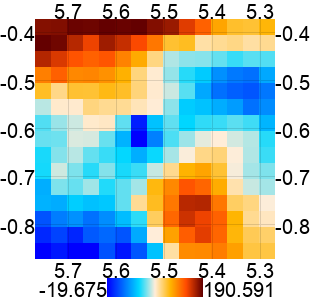

In [4]:
# Choose an object from the catalog
ra, dec = np.deg2rad([ras[16],decs[16]])
width = np.deg2rad(30/60.)

# Build the box around the object and cut out a submap from the larger map
box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
stamp = imap.submap(box)

# Visualize the submap
# Note if using the full map you'll want to only upgrade by a factor of around 4
eshow(stamp, **{"upgrade": 16, "ticks": 0.1, "colorbar": True})

## Stacking point sources and using reproject

If we want to stack objects in the map it's relatively easy to do so, but we need to use a slightly different approach.  Instead of using a bounding box and cutting a submap from the map we can use pixell's `reproject.postage_stamp` function to cut out "stamps" that are reprojected at the center of each object. 

Reprojecting means that we avoid stacking point sources that are distorted due to the rectangular projection of the overall map, as the reprojection will automatically center the "stamp" basis on each individual point source. Users can specify the type of projection using the "proj" keyword. The default is a "gnomonic" projection, but since our stamp size is small, we can keep everything as "car" and continue to use our handy eshow function to build plots.

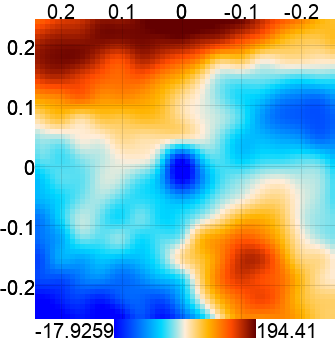

In [5]:
#Reproject the above source and plot
stamp = reproject.postage_stamp(inmap = imap , ra_deg = ras[16], dec_deg = decs[16], width_arcmin = 30.,
                  res_arcmin = .5, proj = 'car')
eshow(stamp, **{"upgrade": 5, "ticks": 0.1, "colorbar": True})

We see the utility of `reproject.postage_stamp` in action: the source is now centered in the new coordinates! Now we stack all of the reprojected sources:

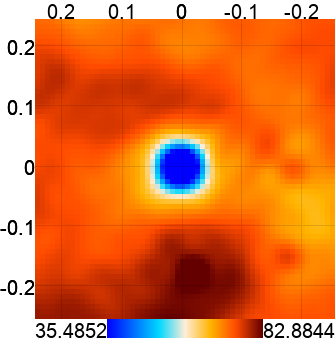

In [6]:
N = len(ras)
stack = 0

for i in range(N):
    # Extract stamps by reprojecting the map at the center of each source.
    # the 'postage_stamp' option here is designed to trim each reprojection so we
    # are left with a stack of point sources in a map of width 30 arc minutes
    stamp = reproject.postage_stamp(inmap = imap , ra_deg = ras[i], dec_deg = decs[i], width_arcmin = 30.,
                  res_arcmin = .5, proj = 'car')
    if stamp is None: continue
    stack += stamp[0]
    
stack /= N
eshow(stack, **{"upgrade": 5, "ticks": 0.1, "colorbar": True})

It looks like the average source in our catalog is a well-defined cold spot relative to the surrounding CMB. This is qualitatively consistent with our understanding of a typical thermal-SZ cluster observed at 150 GHz (see e.g. [Carlstrom et. al. 2002](https://doi.org/10.1146/annurev.astro.40.060401.093803)). We examine tSZ clusters in  more detail in [Section 6](Section_6_Component_separated_maps.ipynb).

## Applications: Aperture Photometry and Radial Binning
Stamps are especially useful for additional analysis techniques that rely on the source being centered in the frame. One such technique is Aperture Photometry (AP), which can be used to calculate the brightness of objects. 

This code calculates the average temperature of an aperture: a circle of radius $x$ centered at the origin. It then finds the temperature of a ring of equal area around the circle (outer radius $\sqrt{2}x$), and subtracts the temperature of this ring from the temperature the aperture.  We repeat this for multiple radii and can then plot the AP result against radii.

In [7]:
def aper_photo(x, radii_map, plot):
    '''calculates the flux-background for a single aperature'''
    zeros = np.zeros(np.shape(radii_map))
    circle_sum = np.mean(np.where(radii_map < x, plot, zeros))
    ring_sum = np.mean(np.where(radii_map < np.sqrt(2)*x, plot, zeros)) - circle_sum
    return (circle_sum - ring_sum)

def aper_plot(r, radii, stamp):
    '''Creates the aperature photometry plot for a given stamp'''
    aper_plot = np.zeros(np.shape(r))
    for i in range(np.size(r)):
        aper_plot[i] = aper_photo(r[i], radii, stamp)
    return aper_plot

0.3476603273933458 0.005892556491721242


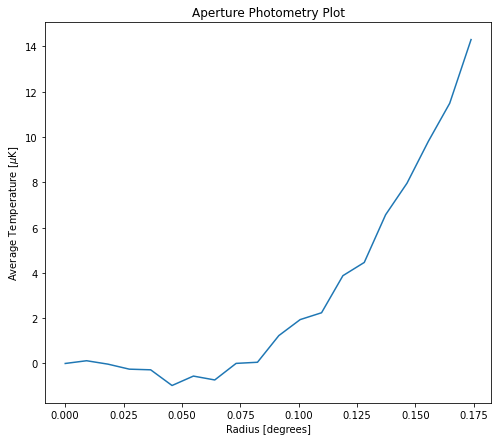

In [8]:
# Call the function modrmap that stores the radii in degrees of each pixel from the center
radii = enmap.modrmap(stamp.shape, stamp.wcs)*180/np.pi

# Determine the bounds for the bins
r_max = np.max(radii)
r_min = np.min(radii)
print(r_max, r_min)
# define the radii we want for the aperature plot, note the maximum aperature radius is chosen to avoid edge effects
r = np.linspace(0, r_max/2, 20)


plt.figure(figsize = (8,7))
plt.title("Aperture Photometry Plot")
plt.xlabel("Radius [degrees]")
plt.ylabel("Average Temperature [$ \mu $K]")
plt.plot(r, aper_plot(r, radii, stamp))
plt.show()

The idea with aperture photometry is that the circle is a guess for the size of the object itself and the ring is the "background". In the plot above, the curve is about zero initially, this is because the outer ring falls entirely within the object, so the background and the circle are close to the same temperature. For greater radii the curve tilts away from zero as the temperature in the two increasingly differ.

## Radial Binning
We will also take a moment to demonstrate how to radially bin a point source to look at the profile. 

Below is code that bins data radially, fits the binned data with an exponential curve, and then creates a 2D profile from the fit to approximate the 2D profile of the point source. This code can of course be adapted for other uses but here we will look at the stack of point sources, since single sources tend to be less radially symmetric. 

In [11]:
def bin_stamp(data2d, modrmap, bin_edges):
    '''gives the centers and averages for radial bins of a 2d plot'''
    #get centers of each bin
    centers = (bin_edges[1:]+bin_edges[:-1])/2.
    
    #sort indices by corresponding radial bin
    digitized = np.digitize(modrmap.reshape(-1), bin_edges,right=True)

    #get average of each radial bin
    count = np.bincount(digitized)[1:-1]
    res = np.bincount(digitized,(data2d).reshape(-1))[1:-1]/count
    return centers,res

In [12]:
# Define the fit function
def func(x, A, B, C):
    return A*np.exp(B*x) + C

# Set the number of bins
N_bins = 50

# r_edge is the radius of the largest circle that can fit entirely within the box
r_edge = r_max/np.sqrt(2)

step = (r_edge - r_min)/N_bins

# Create the bin edges
bin_edges = np.arange(r_min, r_edge, step)

# Use the binner function to get the average temp for each radius
cents, res = bin_stamp(stack, radii, bin_edges)

In [13]:
# Fit the results from the binner with the exponential
popt, pcov = curve_fit(func, cents, res, p0 = [-1, -1, 80])
res_fit = func(cents, popt[0], popt[1], popt[2])

[Text(0, 0.5, 'Temperature [$ \\mu $K]'),
 Text(0.5, 0, 'Radius [degrees]'),
 Text(0.5, 1.0, 'Residuals')]

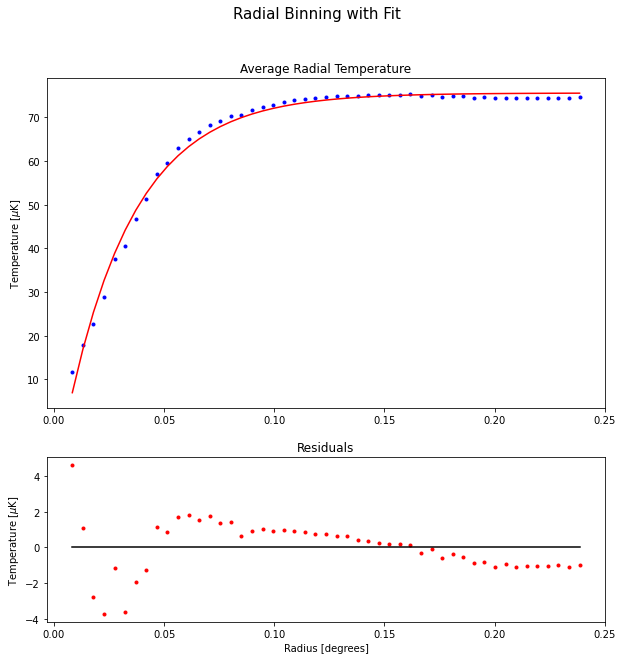

In [14]:
# Plot the radial temp curve and its fit
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), gridspec_kw={'height_ratios': [2, 1]})
fig.figsize = (10, 9)
fig.suptitle('Radial Binning with Fit', fontsize = 15)

ax1.plot(cents, res, 'b.')
ax1.plot(cents, res_fit, 'r')
ax1.set(ylabel = r"Temperature [$ \mu $K]", title = "Average Radial Temperature")
ax2.plot(cents, res - res_fit, 'r.')

ax2.plot(cents, np.zeros(np.size(cents)), 'k')
ax2.set(xlabel = "Radius [degrees]",
        ylabel = r"Temperature [$ \mu $K]", title = "Residuals")

As shown in the plot above the radial binning curve is nearly exponential, with relatively small residuals. This code uses a fit instead of the raw binning data to "smooth" the values a bit, and so that data can be extrapolated past r-edge (where the corners of the stamp would create errors in the radial binning).

Radially binned 2d map


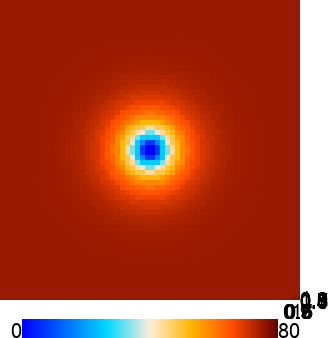

Stack with radial binning subtracted


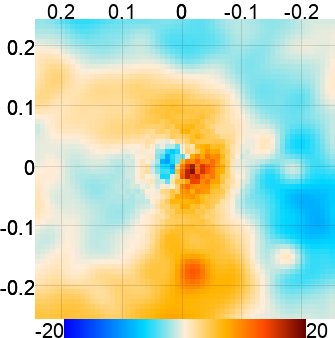

In [16]:
# Use the radial temp fit to get a 2d map
res_fit_2D = np.zeros(np.shape(stack))
for n in range(np.size(cents)):
    res_fit_2D = np.where((radii > cents[n] + step/2), res_fit[n], res_fit_2D)

# Plot the 2d fit map and the original stack with the fit subtracted
print("Radially binned 2d map")
eshow(res_fit_2D, **{"upgrade": 5, "ticks": 0.1, "colorbar": True, "max": 80, "min": 0})
print("Stack with radial binning subtracted")
eshow(stack - res_fit_2D, **{"upgrade": 5, "ticks": 0.1, "colorbar": True, "max": 20, "min": -20})

In the plot above we can see that the stack is slightly asymetric, this is most likely due to random variation which the stack is not large enough to average out, or due to the fact that we are working with the downgraded maps which influence the quality of the fit.  It's also worth noting we've adjusted the scale above in order to make the residuals visible.



## Plot Messier objects

While users are free to search for objects in the maps using catalogs we've also provided a tool to plot random Messier objects from our maps below.  You can enter the Messier number of an object you'd like to look at or feel free to let the function generate an object at random.

In [17]:
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import random 

In [18]:
def plot_messier(M = None):
    # M should be an integer 

    # read in a table of messier objects that overlap with our feild of view
    tbl = ascii.read(path + "messier_objs.csv", encoding = "utf-8-sig")

    # Check if user has given an object to look for
    if M != None:
        M = str('M') + str(M)
        A = list(tbl['M'])
        if M in A:
            obj = tbl[A.index(M)]
        else:
            print("Sorry that object isn't visible in this map")

    # If no object is given select a random one
    if M == None:
        obj = tbl[random.randrange(0, len(tbl))] 

    # Get the RA and DEC of the object
    ra = coord.Angle(obj["RA"], unit=u.hour) 
    dec = coord.Angle(obj["Declination"], unit = u.degree) 

    # Get a plot of the object
    stamp = reproject.postage_stamp(inmap = imap , ra_deg = ra.degree, \
              dec_deg = dec.degree, width_arcmin = 20., res_arcmin = .5)


    # Establish name for the object, if the common name is given use that, if not 
    # we just use the NGC and M indentifiers
    if type(obj["Common Name"] ) == np.str_:
        name = str(obj["Common Name"])  + str(' NGC: ') + str(obj["NGC"]) + \
        str(' ') + str(obj["M"])
    else:
        name = str('NGC: ') + str(obj["NGC"])+ str(' ') + str(obj["M"])

    # Plot the object 
    plt.imshow((stamp[0]))
    plt.title(name)
    plt.show()

    return 

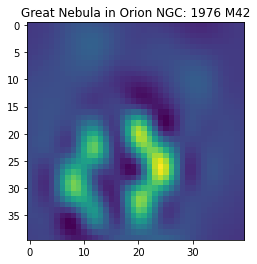

In [21]:
# Try this a few times - some of the objects may be clearer than others
plot_messier()

### Continue to the next section

[Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.